## Paralleled CelebA Image Recognition Based On CNN Deep Learning
### Group 09 Yueheng LI

**Dataset**

For this project I use the CelebA dataset (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), which is available on Kaggle.

Description of the CelebA dataset from kaggle (https://www.kaggle.com/jessicali9530/celeba-dataset):

**Introduction of Dataset**

A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).

**Data Files Overall**

**img_align_celeba.zip:** All the face images, cropped and aligned


**list_eval_partition.csv:** Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing


**list_bbox_celeba.csv:** Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box


**list_landmarks_align_celeba.csv:** Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
    
    
**list_attr_celeba.csv:** Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative


**Environment description**

**Local Environment**

The local configuration of my PC is CPU:Intel i7-10750H GPU:NVIDIA RTX2060 RAM:32GB 

The local environment of my PC:CUDA 11.4 + Tensorflow 2.5

**OOD Environment**

2 Core CPU + K80 GPU

CUDA 11.4 + Tensorflow 2.8

**Discovery Environment**

2x Tesla V100-SXM2-32GB

CUDA 11.4 + Tensorflow 2.8

## 1. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import time
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
print(tf.__version__)

2.8.0


### 1.1. Parallel setup / device check

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8619942655533501526
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11319115776
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 10254236811840101705
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:84:00.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [4]:
!nvidia-smi

Sat Apr 30 18:40:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:84:00.0 Off |                    0 |
| N/A   35C    P0    62W / 149W |    146MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#import tensorflow.compat.v1 as tf

In [4]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

# ------------------------------------------

## 2. Load image label attributes

In [5]:
MAIN_PATH = '../FinalProject/'
DATA_PATH = MAIN_PATH + 'img_align_celeba/img_align_celeba/'
ATTRIBUTE_PATH = MAIN_PATH + 'list_attr_celeba.csv'
TEST_PIC_PATH = './test_pic/'

SMILING_PATH = '../FinalProject/New_data1/'

In [6]:
time1=time.time()
dataset = pd.read_csv(ATTRIBUTE_PATH, index_col='image_id')
time2=time.time()
print("The time of the process:",time2-time1,"s")

The time of the process: 0.5594215393066406 s


### 2.1 With Dask Parallelism

In [7]:
import dask
from dask.distributed import Client

client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:36127 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.00 GiB


In [8]:
import dask.dataframe as dd
import time

time1=time.time()
dataset1 = dd.read_csv(ATTRIBUTE_PATH)
time2=time.time()
print("The time of the process with dask array:",time2-time1,"s")
#dataset1.head()

The time of the process with dask array: 0.018240928649902344 s


In [9]:
dataset

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1


### 2.2 Exploratory Data Analysis

In [10]:
#List of available attributes
for i, j in enumerate(dataset.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Smiling    1
Male      -1
Young      1
Name: 000510.jpg, dtype: int64

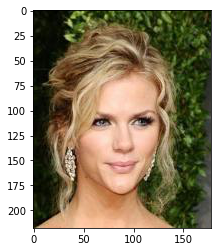

In [11]:
# plot picture and attributes
img = load_img('../FinalProject/img_align_celeba/img_align_celeba/000510.jpg')
plt.grid(False)
plt.imshow(img)
dataset.loc['../FinalProject/img_align_celeba/img_align_celeba/000510.jpg'.split('/')[-1]][['Smiling','Male','Young']] #some attributes

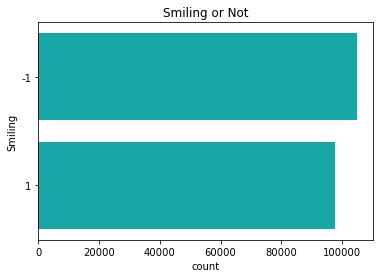

In [12]:
# Female or Male?
plt.title('Smiling or Not')
sns.countplot(y='Smiling', data=dataset, color="c")
plt.show()

In [21]:
#dataset1.replace(-1,0)
# arr=pd.DataFrame(dataset1.iloc[:,1:].sum(axis=0))
# arr.columns=['labels']
# arr.sort_values(by='labels',ascending=False)
# plt.figure(figsize=(16,8))
# plt.bar(arr.index,arr['labels'])
# plt.xticks(rotation=90)
# plt.show()

In [23]:
# import seaborn as sns
# plt.figure(figsize=(16,12))
# sns.heatmap(dataset1.iloc[:,1:].corr(), cmap="RdYlBu", vmin=-1, vmax=1)

## 3. Data pre-processing
*Modified on local machine and we use pre-processed dataset after modification*

In [22]:
# #split the training and testing set
# from sklearn.model_selection import train_test_split
# train_set, test_set = train_test_split(dataset, test_size = 0.2, random_state = 0)

In [17]:
# train_set_not_smiling = train_set.query('Smiling == -1')
# train_set_smiling = train_set.query('Smiling == +1')

# test_set_not_smiling = test_set.query('Smiling == -1')
# test_set_smiling = test_set.query('Smiling == +1')

In [21]:
#Copy the train and test data to the appropriate folder
# import shutil
# import time
# time1=time.time()


# for img in train_set_not_smiling.index.values:
#     shutil.copy(DATA_PATH + img, SMILING_PATH + "train_set/not_smiling")
# for img in train_set_smiling.index.values:
#     shutil.copy(DATA_PATH + img, SMILING_PATH + "train_set/smiling")
# for img in test_set_not_smiling.index.values:
#     shutil.copy(DATA_PATH + img, SMILING_PATH + "test_set/not_smiling")
# for img in test_set_smiling.index.values:
#     shutil.copy(DATA_PATH + img, SMILING_PATH + "test_set/smiling")
    
# time2=time.time()
# print("The time of the process:",time2-time1,"s")

The time of the process: 464.28617238998413 s


## 3. Data Loader（Using keras DataGenerator）

In [13]:
TARGET_SIZE = (64, 64)
BATCH_SIZE = 128
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
time1=time.time()

train_generator = train_datagen.flow_from_directory(
    SMILING_PATH + 'train_set',
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

time2=time.time()
print("The time of the process:",time2-time1,"s")

Found 162079 images belonging to 2 classes.
The time of the process: 4.3606953620910645 s


In [15]:
time1=time.time()

validation_generator = test_datagen.flow_from_directory(
    SMILING_PATH + 'test_set',
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

time2=time.time()
print("The time of the process:",time2-time1,"s")

Found 40520 images belonging to 2 classes.
The time of the process: 1.099318027496338 s


## 4. Building CNN model

### 4.1 Model Definition ：Without Parallel Strategy

In [16]:
#TARGET_SIZE = (64, 64)
#BATCH_SIZE = 128
n_gpus=1

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


classifier1 = Sequential()
classifier1.add(Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))
classifier1.add(MaxPooling2D(pool_size=(2,2)))
classifier1.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
classifier1.add(MaxPooling2D(pool_size=(2,2)))
classifier1.add(Flatten())
classifier1.add(Dense(units= 128, activation='relu'))
classifier1.add(Dense(units= 1, activation='sigmoid'))
classifier1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

### 4.2 Model Definition ：With MirroredStrategy

In [20]:
#TARGET_SIZE = (64, 64)
#BATCH_SIZE = 128
n_gpus=1

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

device_type = 'GPU'
devices = tf.config.experimental.list_physical_devices(device_type)
devices_names = [d.name.split("e:")[1] for d in devices]
print(devices_names)
strategy = tf.distribute.MirroredStrategy(devices= devices_names[:n_gpus])

with strategy.scope():
    classifier2 = Sequential()
    classifier2.add(Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))
    classifier2.add(MaxPooling2D(pool_size=(2,2)))
    classifier2.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
    classifier2.add(MaxPooling2D(pool_size=(2,2)))
    classifier2.add(Flatten())
    classifier2.add(Dense(units= 128, activation='relu'))
    classifier2.add(Dense(units= 1, activation='sigmoid'))
    classifier2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


['GPU:0']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### 4.3 Model Definition ：With OneDeviceStrategy

In [21]:
#TARGET_SIZE = (64, 64)
#BATCH_SIZE = 128
n_gpus=1

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

device_type = 'GPU'
devices = tf.config.experimental.list_physical_devices(device_type)
devices_names = [d.name.split("e:")[1] for d in devices]
print(devices_names)
#strategy = tf.distribute.MirroredStrategy(devices= devices_names[:n_gpus])
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")


with strategy.scope():
    classifier3 = Sequential()
    classifier3.add(Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))
    classifier3.add(MaxPooling2D(pool_size=(2,2)))
    classifier3.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
    classifier3.add(MaxPooling2D(pool_size=(2,2)))
    classifier3.add(Flatten())
    classifier3.add(Dense(units= 128, activation='relu'))
    classifier3.add(Dense(units= 1, activation='sigmoid'))
    classifier3.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


['GPU:0']


In [22]:
#classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print(classifier1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8

In [4]:
# # Allow memory growth for the GPU
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [16]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"

## 5. Model Training

### 5.1 CPU computation
*Modified on local machine (Training on Tensorflow CPU version)*

In [32]:
#"This is CPU computation"
#print("This is CPU computation")
# time1=time.time()
# history = classifier.fit(
#     train_generator,
#     steps_per_epoch = train_generator.samples // train_generator.batch_size,
#     epochs = 12,
#     validation_data = validation_generator,
#     validation_steps = validation_generator.samples // validation_generator.batch_size
# )
# time2=time.time()
# print("The time of the process:",time2-time1,"s")

Epoch 1/12
1266/1266 [==============================] - 408s 313ms/step - loss: 0.3994 - accuracy: 0.8061 - val_loss: 0.2354 - val_accuracy: 0.9011
Epoch 2/12
1266/1266 [==============================] - 391s 309ms/step - loss: 0.2519 - accuracy: 0.8942 - val_loss: 0.2228 - val_accuracy: 0.9075
Epoch 3/12
1266/1266 [==============================] - 396s 313ms/step - loss: 0.2333 - accuracy: 0.9023 - val_loss: 0.2207 - val_accuracy: 0.9071
Epoch 4/12
1266/1266 [==============================] - 397s 314ms/step - loss: 0.2252 - accuracy: 0.9060 - val_loss: 0.2318 - val_accuracy: 0.9019
Epoch 5/12
1266/1266 [==============================] - 1299s 1s/step - loss: 0.2216 - accuracy: 0.9073 - val_loss: 0.2125 - val_accuracy: 0.9107
Epoch 6/12
1266/1266 [==============================] - 368s 291ms/step - loss: 0.2159 - accuracy: 0.9098 - val_loss: 0.2086 - val_accuracy: 0.9120
Epoch 7/12
1266/1266 [==============================] - 386s 305ms/step - loss: 0.2134 - accuracy: 0.9110 - val_lo

### 5.2 GPU computation without parallel strategy

In [23]:
print("This is GPU computation-without parallal strategy:")
time1_1=time.time()
history1 = classifier1.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs = 5,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size
)
time2_1=time.time()
t1=time2_1-time1_1
print("The time of the process:",t1,"s")

This is GPU computation-without parallal strategy:
Epoch 1/5
1266/1266 [==============================] - 385s 303ms/step - loss: 0.3562 - accuracy: 0.8361 - val_loss: 0.2419 - val_accuracy: 0.8973
Epoch 2/5
1266/1266 [==============================] - 375s 296ms/step - loss: 0.2512 - accuracy: 0.8946 - val_loss: 0.2416 - val_accuracy: 0.8973
Epoch 3/5
1266/1266 [==============================] - 375s 296ms/step - loss: 0.2352 - accuracy: 0.9012 - val_loss: 0.2248 - val_accuracy: 0.9047
Epoch 4/5
1266/1266 [==============================] - 385s 304ms/step - loss: 0.2268 - accuracy: 0.9045 - val_loss: 0.2224 - val_accuracy: 0.9070
Epoch 5/5
1266/1266 [==============================] - 387s 305ms/step - loss: 0.2197 - accuracy: 0.9076 - val_loss: 0.2073 - val_accuracy: 0.9117
The time of the process: 2090.4484980106354 s


### 5.3 GPU computation with parallel strategy(MirroredStrategy)

In [24]:
#5.3 GPU computation with parallel strategy(MirroredStrategy)
time1_2=time.time()
history2 = classifier2.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs = 5,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size
)
time2_2=time.time()
t2=time2_2-time1_2
print("This is GPU computation-with Mirrored parallal strategy")
print("The time of the process:",t2,"s")

Epoch 1/5
1266/1266 [==============================] - 388s 305ms/step - loss: 0.3417 - accuracy: 0.8466 - val_loss: 0.2457 - val_accuracy: 0.8965
Epoch 2/5
1266/1266 [==============================] - 383s 302ms/step - loss: 0.2613 - accuracy: 0.8888 - val_loss: 0.2304 - val_accuracy: 0.9021
Epoch 3/5
1266/1266 [==============================] - 418s 330ms/step - loss: 0.2452 - accuracy: 0.8959 - val_loss: 0.2208 - val_accuracy: 0.9081
Epoch 4/5
1266/1266 [==============================] - 381s 301ms/step - loss: 0.2318 - accuracy: 0.9018 - val_loss: 0.2283 - val_accuracy: 0.9037
Epoch 5/5
1266/1266 [==============================] - 385s 304ms/step - loss: 0.2249 - accuracy: 0.9052 - val_loss: 0.2144 - val_accuracy: 0.9083
This is GPU computation-with Mirrored parallal strategy
The time of the process: 1955.1387119293213 s


### 5.4 GPU computation with parallel strategy(OneDeviceStrategy)

In [25]:
# 5.4 GPU computation with parallel strategy(OneDeviceStrategy)
time1_3=time.time()
history3 = classifier3.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs = 5,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size
)
time2_3=time.time()
t3=time2_3-time1_3
print("This is GPU computation-with OneDevice parallal strategy")
print("The time of the process:",t3,"s")

Epoch 1/5
1266/1266 [==============================] - 386s 305ms/step - loss: 0.3500 - accuracy: 0.8398 - val_loss: 0.2615 - val_accuracy: 0.8877
Epoch 2/5
1266/1266 [==============================] - 385s 304ms/step - loss: 0.2647 - accuracy: 0.8882 - val_loss: 0.2337 - val_accuracy: 0.9017
Epoch 3/5
1266/1266 [==============================] - 386s 305ms/step - loss: 0.2498 - accuracy: 0.8940 - val_loss: 0.2252 - val_accuracy: 0.9045
Epoch 4/5
1266/1266 [==============================] - 395s 312ms/step - loss: 0.2409 - accuracy: 0.8983 - val_loss: 0.2388 - val_accuracy: 0.8979
Epoch 5/5
1266/1266 [==============================] - 404s 319ms/step - loss: 0.2324 - accuracy: 0.9019 - val_loss: 0.2197 - val_accuracy: 0.9071
This is GPU computation-with OneDevice parallal strategy
The time of the process: 1956.7674617767334 s


### 5.5 Multi-GPU computation(2 GPU Mirror Strategic)

In [26]:
#TARGET_SIZE = (64, 64)
#BATCH_SIZE = 128
n_gpus=2

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

device_type = 'GPU'
devices = tf.config.experimental.list_physical_devices(device_type)
devices_names = [d.name.split("e:")[1] for d in devices]
print(devices_names)
strategy = tf.distribute.MirroredStrategy(devices= devices_names[:n_gpus])

with strategy.scope():
    classifier4 = Sequential()
    classifier4.add(Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))
    classifier4.add(MaxPooling2D(pool_size=(2,2)))
    classifier4.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
    classifier4.add(MaxPooling2D(pool_size=(2,2)))
    classifier4.add(Flatten())
    classifier4.add(Dense(units= 128, activation='relu'))
    classifier4.add(Dense(units= 1, activation='sigmoid'))
    classifier4.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


['GPU:0']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [27]:
#Multi-GPU computation(2 GPU Mirror Strategic)
time1_4=time.time()
history4 = classifier4.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs = 5,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size
)
time2_4=time.time()
t4=time2_4-time1_4
print("This is Multi-GPU computation(2 GPU Mirror Strategic)")
print("The time of the process:",t4,"s")

Epoch 1/5
1266/1266 [==============================] - 392s 308ms/step - loss: 0.3545 - accuracy: 0.8356 - val_loss: 0.2833 - val_accuracy: 0.8768
Epoch 2/5
1266/1266 [==============================] - 427s 337ms/step - loss: 0.2600 - accuracy: 0.8903 - val_loss: 0.2352 - val_accuracy: 0.9016
Epoch 3/5
1266/1266 [==============================] - 398s 315ms/step - loss: 0.2412 - accuracy: 0.8984 - val_loss: 0.2180 - val_accuracy: 0.9072
Epoch 4/5
1266/1266 [==============================] - 395s 312ms/step - loss: 0.2326 - accuracy: 0.9021 - val_loss: 0.2208 - val_accuracy: 0.9054
Epoch 5/5
1266/1266 [==============================] - 393s 310ms/step - loss: 0.2254 - accuracy: 0.9054 - val_loss: 0.2224 - val_accuracy: 0.9055
This is Multi-GPU computation(2 GPU Mirror Strategic)
The time of the process: 2006.0654919147491 s


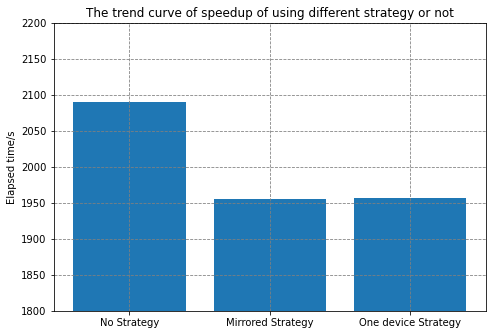

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ["No Strategy", "Mirrored Strategy","One device Strategy"]
students = [t1,t2,t3]
ax.bar(langs,students)
plt.ylim((1800, 2200))
ax.set_ylabel('Elapsed time/s')
ax.set_title('The trend curve of speedup of using different strategy or not')
plt.grid(color = 'grey', linestyle = 'dashed')
plt.savefig("CNN.png")
plt.show()

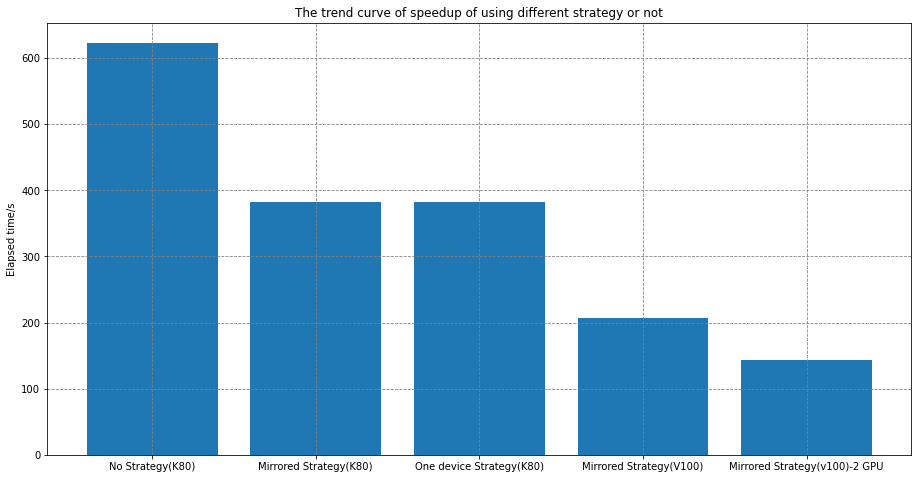

In [34]:
import matplotlib.pyplot as plt
y=[622,382,382,207,143]
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0,0,1,1])
x_label = ["No Strategy(K80)", "Mirrored Strategy(K80)","One device Strategy(K80)", "Mirrored Strategy(V100)", "Mirrored Strategy(v100)-2 GPU"]
#plt.xticks(x, x_label)
#students = [t1,t2,t3,t4,t5]
#plt.figure(figsize=(20, 6.5))
ax.bar(x_label,y,width=0.8)
#plt.ylim((1800, 2200))
ax.set_ylabel('Elapsed time/s')
ax.set_title('The trend curve of speedup of using different strategy or not')
plt.grid(color = 'grey', linestyle = 'dashed')
plt.savefig("CNN2.png")
plt.show()

## 6. Save the CNN model
*Modified on local machine*

In [63]:
#classifier.save('C:/Users/Razer/Desktop/Data/smiling_model.h5')

In [57]:
# from keras.models import load_model
# classifier= load_model('./exported_model/smiling_model.h5')

## 7. Result analysis
*Modified on local machine(Version with 10 epoches) *

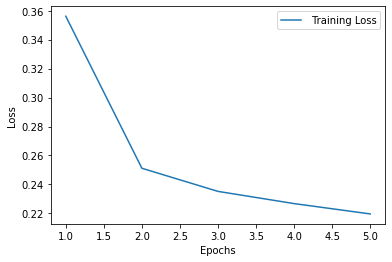

In [36]:
loss_values = history1.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label=' Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

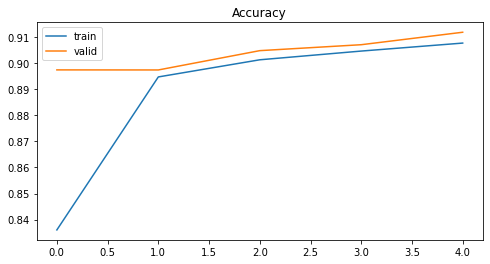

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(history1.history['accuracy'], label = 'train')
plt.plot(history1.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

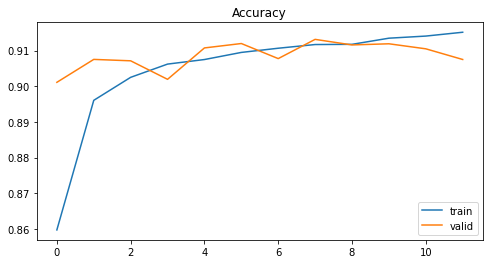

In [53]:
#The plot comes from original 12 epoch CPU training result
# plt.figure(figsize=(8, 4))
# plt.plot(history.history['accuracy'], label = 'train')
# plt.plot(history.history['val_accuracy'], label = 'valid')
# plt.legend()
# plt.title('Accuracy')
# plt.show()

In [ ]:
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# print(classification_report(y_val, predictions))

In [38]:
time1=time.time()
results = classifier1.evaluate(validation_generator, verbose=0)
#results
time2=time.time()
print("The time of the process with dask array:",time2-time1,"s")

The time of the process with dask array: 48.085185527801514 s


In [39]:
results

[0.20723605155944824, 0.9117719531059265]

In [77]:
# predictions = classifier1.predict(validation_generator)
# predictions = (predictions > 0.5)

In [1]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# cm = confusion_matrix(validation_generator.classes, predictions)
# plt.figure(figsize=(6,6))
# sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r")
# plt.xlabel("Predicted label")
# plt.ylabel("Actual label")
# plt.show()

# -------------------------------------------------------------

## 8. Predict a single image

In [18]:
from keras_preprocessing import image

def classify(imagePath):
    test_image = image.load_img(imagePath, target_size = (64, 64))
    test_image = image.img_to_array(test_image).astype('float32') / 255 
    test_image = np.expand_dims(test_image, axis = 0) # add an extra dimension to fake batch

    result = classifier1.predict(test_image)
    if result[0][0] >= 0.5:
        prediction = 'smiling'
        probability = result[0][0]
    else:
        prediction = 'not smiling'
        probability = 1 - result[0][0]
    print("This person is " + prediction + " (" + str(probability * 100) + "%).")

In [19]:
from keras.preprocessing.image import load_img

def showImage(imagePath):
    img = load_img(imagePath)
    plt.imshow(img)
    plt.show()

This person is smiling (99.86271858215332%).


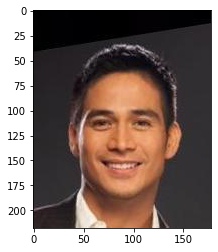

In [42]:
imageToClassify = DATA_PATH + "000012.jpg" # Can test from 0 to 3
classify(imageToClassify)
showImage(imageToClassify)

## ----------------------- END -----------------------------